# ОБУЧЕНИЕ POINTNET СЕТЕЙ ПО КЛАССИФИКАЦИИ НА ОСНОВЕ ОБЛАКОВ ТОЧЕК ВЭКГ

In [1]:
import os
import numpy as np
import itertools
import math, random
from glob import glob

from func import *
from model import *

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pandas as pd

import scipy.spatial.distance
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Установка Seed для воспроизводимости
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

Демонстрация нормализации (StandardScaler) исходных облаков точек:

In [8]:
file_path = 'final_pointcloud_dataset/train/AG42_period_2.csv'
#file_path_normalized = 'final_pointcloud_dataset_normalized/train/AG2_period_3.csv'

print('Исходное облако точек:')
# Чтение CSV-файла
df = pd.read_csv(file_path)
point_cloud_array = df[['x', 'y', 'z']].values
pcshow(*point_cloud_array.T)


#print('Нормализованное облако точек:')
# Чтение CSV-файла
#df_normalized = pd.read_csv(file_path_normalized)
#point_cloud_array = df_normalized[['x', 'y', 'z']].values
#pcshow(*point_cloud_array.T)

Исходное облако точек:


---

# Преподготовка данных перд обучением сетей:

Кастомные траснсформации датасета:

In [9]:
# Реализация нормального шума
class RandomNoise(object):
    def __init__(self, std=0.002):
        self.std = std
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, self.std, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud


class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

# Реализация нормализации чтобы максильное значение равнялось 1 (схоже с методом в изображениях)
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud


# Создание рандомного семплирования (если точек меньше то просто добавлю дубликаты чтобы добить число)
class PointSampler:
    def __init__(self, num_points=512): 
        self.num_points = num_points

    def __call__(self, pointcloud):
        num_total_points = pointcloud.shape[0]
        
        if num_total_points < self.num_points:
              
            # Семплирование оставшихся точек из уже существующих точек
            sampled_indices = np.random.choice(num_total_points, self.num_points - num_total_points, replace=True)
            duplicated_points = pointcloud[sampled_indices, :]
            
            # Собираем все точки в итоговую выборку
            sampled_points = np.vstack((pointcloud, duplicated_points))
            #print("Всего точек меньше чем надо семплировать - будут дубликаты")
        else:
            # Случайно берем точки:
            sampled_indices = np.random.choice(num_total_points, self.num_points, replace=False)
            sampled_points = pointcloud[sampled_indices, :]
        
        return sampled_points

# Создание рандомного семплирования  с попыткой брать больше точек что дальше лежат от (0,0) 
# (если точек меньше то просто добавлю дубликаты чтобы добить число)
class PointSampler_weighted:
    def __init__(self, num_points=512): 
        self.num_points = num_points

    def __call__(self, pointcloud):
        num_total_points = pointcloud.shape[0]
        
        if num_total_points < self.num_points:
              
            # Семплирование оставшихся точек из уже существующих точек
            sampled_indices = np.random.choice(num_total_points, self.num_points - num_total_points, replace=True)
            duplicated_points = pointcloud[sampled_indices, :]
            
            # Собираем все точки в итоговую выборку
            sampled_points = np.vstack((pointcloud, duplicated_points))
            #print("Всего точек меньше чем надо семплировать - будут дубликаты")
        else:
            # Выше вероятность чем дальше от 0,0
            distances = np.linalg.norm(pointcloud, axis=1)
            weights = distances / np.sum(distances)

            sampled_indices = np.random.choice(num_total_points, self.num_points, replace=False, p=weights)
            sampled_points = pointcloud[sampled_indices, :]
        
        return sampled_points

__Пример нормализации с приведением максильного значения к 1:__

In [10]:
point_cloud_array = df[['x', 'y', 'z']].values
norm_pointcloud = Normalize()(point_cloud_array)
pcshow(*norm_pointcloud.T)

__Пример добавления небольшого шума:__

In [11]:
sampled_point_cloud = RandomNoise(std=0.00)(norm_pointcloud)
pcshow(*sampled_point_cloud.T)

__Семплирование точек:__ <br>
Пример с семплированием без весов:

In [12]:
sampled_point_cloud = PointSampler(100)(norm_pointcloud)
pcshow(*sampled_point_cloud.T)

Пример с семплированием c весами (делает шанс выбора точек более удаленных от начала координат более высоким):

In [13]:
sampled_point_cloud = PointSampler_weighted(100)(norm_pointcloud)
pcshow(*sampled_point_cloud.T)

In [14]:
# Класс Датасета
class PointCloudData(Dataset):
    def __init__(self, root, subset_type, transform=None):

        self.df_gt = pd.read_csv(f"{root}/{subset_type}/ground_truth.csv", index_col=0)

        self.df_gt['class'] = self.df_gt['EF'].apply(lambda x: 1 if x < 50 else 0)

        self.csv_paths = glob(f"{root}/{subset_type}/*.csv")
        self.csv_paths = [path for path in self.csv_paths if path != f"{root}/{subset_type}\\ground_truth.csv"]
        self.transform = transform
        self.classes = {0 : 'normal', 1 : 'pathology'}
        self.class_counts = self.df_gt['class'].value_counts().to_dict()

    def __len__(self):
        return len(self.csv_paths)


    def __getitem__(self, idx):

        file_path = self.csv_paths[idx]
        df = pd.read_csv(file_path)
        point_cloud = df[['x', 'y', 'z']].values

        if self.transform:
            pointcloud = self.transform(point_cloud)

        target = self.df_gt.loc[os.path.basename(file_path)]['class'] 

        return  {'pointcloud': pointcloud, 
                'category': target}


In [15]:
# КОНСТАНТЫ:
BATCH_SIZE = 256

# Путь к корневой папке датасета
DATASET_PATH = "final_pointcloud_dataset"

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [16]:
train_transforms = transforms.Compose([
                    Normalize(),
                    PointSampler_weighted(512),
                    RandomNoise(std=0.001),
                    ToTensor()
                    ])

val_transforms = transforms.Compose([
                    Normalize(),
                    PointSampler_weighted(512),
                    ToTensor()
                    ])

train_ds = PointCloudData(DATASET_PATH, "train", transform=train_transforms)
valid_ds = PointCloudData(DATASET_PATH, "val", transform=val_transforms)

train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=BATCH_SIZE)

In [18]:
train_ds.class_counts

{0: 4360, 1: 1855}

In [19]:
classes = {'normal' : 0, 'pathology': 1}
inv_classes = {0 : 'normal', 1 : 'pathology'}
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))

i = random.randrange(len(train_ds))
print('\nПример элемента тренировочного датасета:')
print('Sample pointcloud shape: ', train_ds[i]['pointcloud'].size())
print('Class: ', inv_classes[train_ds[i]['category']])
pcshow(*train_ds[i]['pointcloud'].T)

Train dataset size:  6215
Valid dataset size:  2021
Number of classes:  2

Пример элемента тренировочного датасета:
Sample pointcloud shape:  torch.Size([512, 3])
Class:  normal


# ОБУЧЕНИЕ НЕЙРОСЕТИ:

### Как запустить сервер MLflow:
```
mlflow server --backend-store-uri "file:///C:/ML_flow_server" --host localhost --port 5000
```
По этой ссылке будет доступен MLflow: http://localhost:5000

In [20]:
# Инициализация MLflow
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("VECG_POINTNET_Classification")

<Experiment: artifact_location='mlflow-artifacts:/938020304188881611', creation_time=1693415462481, experiment_id='938020304188881611', last_update_time=1693415462481, lifecycle_stage='active', name='VECG_POINTNET_Classification', tags={}>

In [21]:
# Определение количества итераций в одной эпохе
iterations_per_epoch = len(train_loader)
print('Число градиентных спусков за 1 эпоху раняется', iterations_per_epoch)

Число градиентных спусков за 1 эпоху раняется 24


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pointnet = PointNet()
pointnet.to(device)

PointNet(
  (transform): Transform(
    (input_transform): Tnet(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (feature_transform): Tnet(
      (conv1): Conv1d(64, 64, kernel_size=(1,

В PointNet классификаторе используется комбинированная функция потерь:

NLLLoss (Negative Log Likelihood Loss): Это стандартная функция потерь для задач классификации с несколькими классами. Она вычисляет отрицательный логарифм вероятности правильного класса для каждого образца и усредняет результаты по всем образцам в пакете.

Loss_reg (Дополнительная регуляризационная потеря): Эта часть функции потерь представляет собой норму разности между идентичной матрицей и произведением аффинных трансформаций. Она используется для принудительного ортогонализации и/или единичности матриц трансформации. Это помогает сохранить структурные свойства данных в процессе обучения.

Сумма этих двух компонентов образует итоговую функцию потерь

---

In [15]:
train_pointnet(model_pointnet=PointNet, dataloader_train=train_loader, dataloader_val=valid_loader,
                     batch_size=BATCH_SIZE, 
                     name_save='pointnet', start_weight=None, 
                     name_experiment='train small lr', lr=0.00025, epochs=30,
                     scheduler=True, scheduler_step_size=10, dataset_name=DATASET_PATH,
                     f_sampling=700, seed=42,
                     normalize='Centering and max value scaling', gamma=0.5, noise_std=0.001)

Epoch 1/30, Train Loss: 0.4107, Train Aсс: 0.8322 Val Loss: 0.7116, Val Acc:0.6955 
Epoch 5/30, Train Loss: 0.1032, Train Aсс: 0.9635 Val Loss: 0.4166, Val Acc:0.8287 
Epoch 10/30, Train Loss: 0.0467, Train Aсс: 0.9867 Val Loss: 0.3295, Val Acc:0.8754 
Epoch 15/30, Train Loss: 0.0110, Train Aсс: 0.9983 Val Loss: 0.4252, Val Acc:0.8599 
Epoch 20/30, Train Loss: 0.0221, Train Aсс: 0.9913 Val Loss: 0.4825, Val Acc:0.8754 
Epoch 25/30, Train Loss: 0.0049, Train Aсс: 1.0000 Val Loss: 0.3334, Val Acc:0.8893 
Epoch 30/30, Train Loss: 0.0039, Train Aсс: 1.0000 Val Loss: 0.3852, Val Acc:0.8772 
Обучение завершено
Сохранена модель models/pointnet.pth с лучшим weighted avg f1 на валидации = 0.889273356401384
Accuracy данной модели равно 0.889273356401384


In [16]:
train_pointnet(model_pointnet=PointNet, dataloader_train=train_loader, dataloader_val=valid_loader,
                     batch_size=BATCH_SIZE, 
                     name_save='pointnet', start_weight=None, 
                     name_experiment='train big lr', lr=0.001, epochs=30,
                     scheduler=True, scheduler_step_size=10, dataset_name=DATASET_PATH,
                     f_sampling=700, seed=42,
                     normalize='Centering and max value scaling', gamma=0.5, noise_std=0.001)

Epoch 1/30, Train Loss: 0.4044, Train Aсс: 0.8287 Val Loss: 1.2450, Val Acc:0.6955 
Epoch 5/30, Train Loss: 0.1426, Train Aсс: 0.9485 Val Loss: 0.4524, Val Acc:0.8356 
Epoch 10/30, Train Loss: 0.0829, Train Aсс: 0.9763 Val Loss: 0.4104, Val Acc:0.8529 
Epoch 15/30, Train Loss: 0.0214, Train Aсс: 0.9954 Val Loss: 0.5885, Val Acc:0.8322 
Epoch 20/30, Train Loss: 0.0252, Train Aсс: 0.9931 Val Loss: 0.6609, Val Acc:0.8218 
Epoch 25/30, Train Loss: 0.0056, Train Aсс: 1.0000 Val Loss: 0.5477, Val Acc:0.8374 
Epoch 30/30, Train Loss: 0.0070, Train Aсс: 0.9983 Val Loss: 0.6534, Val Acc:0.8114 
Обучение завершено
Сохранена модель models/pointnet.pth с лучшим weighted avg f1 на валидации = 0.8675109787064137
Accuracy данной модели равно 0.870242214532872


In [17]:
train_pointnet(model_pointnet=PointNet, dataloader_train=train_loader, dataloader_val=valid_loader,
                     batch_size=BATCH_SIZE, 
                     name_save='pointnet', start_weight=None, 
                     name_experiment='train big lr fast sheduler', lr=0.001, epochs=30,
                     scheduler=True, scheduler_step_size=5, dataset_name=DATASET_PATH,
                     f_sampling=700, seed=42,
                     normalize='Centering and max value scaling', gamma=0.5, noise_std=0.001)

Epoch 1/30, Train Loss: 0.4044, Train Aсс: 0.8287 Val Loss: 1.2450, Val Acc:0.6955 
Epoch 5/30, Train Loss: 0.1426, Train Aсс: 0.9485 Val Loss: 0.4524, Val Acc:0.8356 
Epoch 10/30, Train Loss: 0.1074, Train Aсс: 0.9664 Val Loss: 0.4312, Val Acc:0.8564 
Epoch 15/30, Train Loss: 0.0111, Train Aсс: 0.9988 Val Loss: 0.4652, Val Acc:0.8720 
Epoch 20/30, Train Loss: 0.0078, Train Aсс: 0.9994 Val Loss: 0.4996, Val Acc:0.8495 
Epoch 25/30, Train Loss: 0.0057, Train Aсс: 1.0000 Val Loss: 0.4881, Val Acc:0.8702 
Epoch 30/30, Train Loss: 0.0053, Train Aсс: 1.0000 Val Loss: 0.4977, Val Acc:0.8564 
Обучение завершено
Сохранена модель models/pointnet.pth с лучшим weighted avg f1 на валидации = 0.875697566189204
Accuracy данной модели равно 0.8788927335640139


In [18]:
train_pointnet(model_pointnet=PointNet, dataloader_train=train_loader, dataloader_val=valid_loader,
                     batch_size=BATCH_SIZE, 
                     name_save='pointnet', start_weight=None, 
                     name_experiment='train small lr no sheduler', lr=0.00025, epochs=30,
                     scheduler=False,  dataset_name=DATASET_PATH,
                     f_sampling=700, seed=42,
                     normalize='Centering and max value scaling', noise_std=0.001)

Epoch 1/30, Train Loss: 0.4107, Train Aсс: 0.8322 Val Loss: 0.7116, Val Acc:0.6955 
Epoch 5/30, Train Loss: 0.1032, Train Aсс: 0.9635 Val Loss: 0.4166, Val Acc:0.8287 
Epoch 10/30, Train Loss: 0.0467, Train Aсс: 0.9867 Val Loss: 0.3295, Val Acc:0.8754 
Epoch 15/30, Train Loss: 0.0169, Train Aсс: 0.9954 Val Loss: 0.5199, Val Acc:0.8339 
Epoch 20/30, Train Loss: 0.0269, Train Aсс: 0.9925 Val Loss: 0.6694, Val Acc:0.8218 
Epoch 25/30, Train Loss: 0.0138, Train Aсс: 0.9977 Val Loss: 0.3753, Val Acc:0.8651 
Epoch 30/30, Train Loss: 0.0107, Train Aсс: 0.9994 Val Loss: 0.5661, Val Acc:0.8668 
Обучение завершено
Сохранена модель models/pointnet.pth с лучшим weighted avg f1 на валидации = 0.8852460036491079
Accuracy данной модели равно 0.8858131487889274


__Более высокий рандомный шум на трейновых данных:__

In [19]:
train_transforms = transforms.Compose([
                    Normalize(),
                    PointSampler_weighted(512),
                    RandomNoise(std=0.005),
                    ToTensor()
                    ])

val_transforms = transforms.Compose([
                    Normalize(),
                    PointSampler_weighted(512),
                    ToTensor()
                    ])
                    
DATASET_PATH = "final_pointcloud_dataset"
train_ds = PointCloudData(DATASET_PATH, "train", transform=train_transforms)
valid_ds = PointCloudData(DATASET_PATH, "val", transform=val_transforms)

train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=BATCH_SIZE)

pcshow(*train_ds[0]['pointcloud'].T)

In [20]:
train_pointnet(model_pointnet=PointNet, dataloader_train=train_loader, dataloader_val=valid_loader,
                     batch_size=BATCH_SIZE, 
                     name_save='pointnet', start_weight=None, 
                     name_experiment='train big lr noisy', lr=0.001, epochs=30,
                     scheduler=True, scheduler_step_size=10, dataset_name=DATASET_PATH,
                     f_sampling=700, seed=42,
                     normalize='Centering and max value scaling', gamma=0.5, noise_std=0.005)

Epoch 1/30, Train Loss: 0.4035, Train Aсс: 0.8125 Val Loss: 0.8593, Val Acc:0.6955 
Epoch 5/30, Train Loss: 0.1591, Train Aсс: 0.9387 Val Loss: 0.5548, Val Acc:0.8270 
Epoch 10/30, Train Loss: 0.0764, Train Aсс: 0.9786 Val Loss: 0.5330, Val Acc:0.8702 
Epoch 15/30, Train Loss: 0.0219, Train Aсс: 0.9931 Val Loss: 0.5874, Val Acc:0.8149 
Epoch 20/30, Train Loss: 0.0264, Train Aсс: 0.9925 Val Loss: 0.5399, Val Acc:0.8356 
Epoch 25/30, Train Loss: 0.0082, Train Aсс: 0.9988 Val Loss: 0.4728, Val Acc:0.8616 
Epoch 30/30, Train Loss: 0.0026, Train Aсс: 1.0000 Val Loss: 0.6715, Val Acc:0.8356 
Обучение завершено
Сохранена модель models/pointnet.pth с лучшим weighted avg f1 на валидации = 0.8721548666560252
Accuracy данной модели равно 0.870242214532872


In [21]:
train_pointnet(model_pointnet=PointNet, dataloader_train=train_loader, dataloader_val=valid_loader,
                     batch_size=BATCH_SIZE, 
                     name_save='pointnet', start_weight=None, 
                     name_experiment='train big lr fast sheduler noisy', lr=0.001, epochs=30,
                     scheduler=True, scheduler_step_size=5, dataset_name=DATASET_PATH,
                     f_sampling=700, seed=42,
                     normalize='Centering and max value scaling', gamma=0.5, noise_std=0.005)

Epoch 1/30, Train Loss: 0.4035, Train Aсс: 0.8125 Val Loss: 0.8593, Val Acc:0.6955 
Epoch 5/30, Train Loss: 0.1591, Train Aсс: 0.9387 Val Loss: 0.5548, Val Acc:0.8270 
Epoch 10/30, Train Loss: 0.0509, Train Aсс: 0.9844 Val Loss: 0.4503, Val Acc:0.8564 
Epoch 15/30, Train Loss: 0.0102, Train Aсс: 0.9983 Val Loss: 0.5170, Val Acc:0.8512 
Epoch 20/30, Train Loss: 0.0056, Train Aсс: 0.9994 Val Loss: 0.5554, Val Acc:0.8564 
Epoch 25/30, Train Loss: 0.0043, Train Aсс: 1.0000 Val Loss: 0.5187, Val Acc:0.8685 
Epoch 30/30, Train Loss: 0.0046, Train Aсс: 1.0000 Val Loss: 0.5226, Val Acc:0.8581 
Обучение завершено
Сохранена модель models/pointnet.pth с лучшим weighted avg f1 на валидации = 0.8718701155046646
Accuracy данной модели равно 0.8754325259515571


__Без аддитивного шума на трейновых данных:__

In [23]:
train_transforms = transforms.Compose([
                    Normalize(),
                    PointSampler_weighted(512),
                    ToTensor()
                    ])
                    
val_transforms = transforms.Compose([
                    Normalize(),
                    PointSampler_weighted(512),
                    ToTensor()
                    ])

BATCH_SIZE=256
DATASET_PATH = "final_pointcloud_dataset"
train_ds = PointCloudData(DATASET_PATH, "train", transform=train_transforms)
valid_ds = PointCloudData(DATASET_PATH, "val", transform=val_transforms)

train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=BATCH_SIZE, shuffle=False)

In [24]:
train_pointnet(model_pointnet=PointNet, dataloader_train=train_loader, dataloader_val=valid_loader,
                     batch_size=BATCH_SIZE, 
                     name_save='pointnet_no_noise_no_sh', start_weight=None, 
                     name_experiment='train small lr no sheduler without noise', lr=0.00025, epochs=40,
                     scheduler=False,  dataset_name=DATASET_PATH,
                     f_sampling=1000, seed=42,
                     normalize='Centering and max value scaling', noise_std=0)

Epoch 1/40, Train Loss: 0.4549, Train Aсс: 0.7928 Val Loss: 0.5960, Val Acc:0.7041 
Epoch 5/40, Train Loss: 0.1066, Train Aсс: 0.9613 Val Loss: 0.6314, Val Acc:0.7808 


KeyboardInterrupt: 

In [ ]:
train_pointnet(model_pointnet=PointNet, dataloader_train=train_loader, dataloader_val=valid_loader,
                     batch_size=BATCH_SIZE, 
                     name_save='pointnet_no_noise_with_sh', start_weight=None, 
                     name_experiment='train small lr without noise', lr=0.00025, epochs=35,
                     scheduler=True, scheduler_step_size=12, dataset_name=DATASET_PATH,
                     f_sampling=1000, seed=42,
                     normalize='Centering and max value scaling', gamma=0.5, noise_std=0)

Epoch 1/35, Train Loss: 0.4500, Train Aсс: 0.7926 Val Loss: 1.0725, Val Acc:0.3676 
Epoch 5/35, Train Loss: 0.0996, Train Aсс: 0.9650 Val Loss: 0.5783, Val Acc:0.8446 
Epoch 10/35, Train Loss: 0.0417, Train Aсс: 0.9873 Val Loss: 0.6895, Val Acc:0.8408 
Epoch 15/35, Train Loss: 0.0065, Train Aсс: 0.9990 Val Loss: 0.7259, Val Acc:0.8455 
Epoch 20/35, Train Loss: 0.0037, Train Aсс: 0.9995 Val Loss: 0.7937, Val Acc:0.8376 


fine-tuned:

In [50]:
train_pointnet(model_pointnet=PointNet, dataloader_train=train_loader, dataloader_val=valid_loader,
                     batch_size=BATCH_SIZE, 
                     name_save='FT_pointnet_no_noise_no_sh', start_weight='models/pointnet.pth', 
                     name_experiment='FT train small lr no sheduler without noise', lr=0.00025, epochs=30,
                     scheduler=False,  dataset_name=DATASET_PATH,
                     f_sampling=1000, seed=42,
                     normalize='Centering and max value scaling', noise_std=0)

Epoch 1/20, Train Loss: 0.8364, Train Aсс: 0.8145 Val Loss: 0.5417, Val Acc:0.7507 
Epoch 5/20, Train Loss: 0.1134, Train Aсс: 0.9584 Val Loss: 0.5984, Val Acc:0.8263 
Epoch 10/20, Train Loss: 0.0463, Train Aсс: 0.9841 Val Loss: 0.7432, Val Acc:0.8286 
Epoch 15/20, Train Loss: 0.0139, Train Aсс: 0.9970 Val Loss: 0.7066, Val Acc:0.8333 
Epoch 20/20, Train Loss: 0.0163, Train Aсс: 0.9952 Val Loss: 0.8227, Val Acc:0.8488 
Обучение завершено
Сохранена модель models/FT_pointnet_no_noise_no_sh.pth с лучшим weighted avg f1 на валидации = 0.8474966834174047
Accuracy данной модели равно 0.8488262910798122


---

## __Решение проблемы с диспропорцией классов:__

In [25]:
import random

class PointCloudData_balanced(Dataset):
    def __init__(self, root, subset_type, transform=None):

        self.df_gt = pd.read_csv(f"{root}/{subset_type}/ground_truth.csv", index_col=0)

        self.df_gt['class'] = self.df_gt['EF'].apply(lambda x: 1 if x < 50 else 0)

        self.csv_paths = glob(f"{root}/{subset_type}/*.csv")
        self.csv_paths = [path for path in self.csv_paths if path != f"{root}/{subset_type}\\ground_truth.csv"]
        
        # Сбалансированный список индексов для каждого класса
        self.balanced_indices = self.balance_classes()
        
        self.transform = transform
        self.classes = {0 : 'normal', 1 : 'pathology'}

    def __len__(self):
        return len(self.balanced_indices)

    def __getitem__(self, idx):
        idx = self.balanced_indices[idx]
        file_path = self.csv_paths[idx]
        df = pd.read_csv(file_path)
        point_cloud = df[['x', 'y', 'z']].values

        if self.transform:
            pointcloud = self.transform(point_cloud)

        target = self.df_gt.loc[os.path.basename(file_path)]['class'] 

        return  {'pointcloud': pointcloud, 
                'category': target}

    def balance_classes(self):
        # Находим индексы образцов для каждого класса
        normal_indices = [idx for idx, path in enumerate(self.csv_paths) if self.df_gt.loc[os.path.basename(path)]['class'] == 0]
        pathology_indices = [idx for idx, path in enumerate(self.csv_paths) if self.df_gt.loc[os.path.basename(path)]['class'] == 1]
        
        # Определяем больший и меньший класс
        if len(normal_indices) > len(pathology_indices):
            major_class_indices = normal_indices
            minor_class_indices = pathology_indices
        else:
            major_class_indices = pathology_indices
            minor_class_indices = normal_indices
        
        # Дублируем случайные индексы из меньшего класса до тех пор, пока классы не сбалансируются
        balanced_indices = major_class_indices.copy()
        while len(balanced_indices) < len(major_class_indices*2):
            balanced_indices.append(random.choice(minor_class_indices))
        
        return balanced_indices


In [26]:
train_transforms = transforms.Compose([
                    Normalize(),
                    PointSampler_weighted(512),
                    ToTensor()
                    ])
                    
val_transforms = transforms.Compose([
                    Normalize(),
                    PointSampler_weighted(512),
                    ToTensor()
                    ])

DATASET_PATH = "final_pointcloud_dataset"
train_ds = PointCloudData_balanced(DATASET_PATH, "train", transform=train_transforms)
valid_ds = PointCloudData_balanced(DATASET_PATH, "val", transform=val_transforms)

train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=BATCH_SIZE, shuffle=False)

In [27]:
# Определение количества итераций в одной эпохе
iterations_per_epoch = len(train_loader)
print('Число градиентных спусков за 1 эпоху раняется', iterations_per_epoch)

Число градиентных спусков за 1 эпоху раняется 34


no tf:

In [28]:
train_pointnet(model_pointnet=PointNet, dataloader_train=train_loader, dataloader_val=valid_loader,
                     batch_size=BATCH_SIZE, 
                     name_save='pointnet_no_noise_with_sh', start_weight=None, 
                     name_experiment='Баланс train small lr without noise', lr=0.00025, epochs=30,
                     scheduler=True, scheduler_step_size=12, dataset_name=DATASET_PATH,
                     f_sampling=1000, seed=42,
                     normalize='Centering and max value scaling', gamma=0.5, noise_std=0)

Epoch 1/30, Train Loss: 0.3970, Train Aсс: 0.8196 Val Loss: 1.0268, Val Acc:0.5068 
Epoch 5/30, Train Loss: 0.0703, Train Aсс: 0.9753 Val Loss: 0.9713, Val Acc:0.7407 
Epoch 10/30, Train Loss: 0.0600, Train Aсс: 0.9818 Val Loss: 1.5650, Val Acc:0.7123 
Epoch 15/30, Train Loss: 0.0038, Train Aсс: 1.0000 Val Loss: 1.1842, Val Acc:0.7642 
Epoch 20/30, Train Loss: 0.0021, Train Aсс: 1.0000 Val Loss: 1.3088, Val Acc:0.7568 
Epoch 25/30, Train Loss: 0.0026, Train Aсс: 0.9997 Val Loss: 1.3621, Val Acc:0.7632 
Epoch 30/30, Train Loss: 0.0017, Train Aсс: 1.0000 Val Loss: 1.4045, Val Acc:0.7593 
Обучение завершено
Сохранена модель models/pointnet_no_noise_with_sh.pth с лучшим weighted avg f1 на валидации = 0.7743148977167623
Accuracy данной модели равно 0.7770655270655271


In [29]:
train_pointnet(model_pointnet=PointNet, dataloader_train=train_loader, dataloader_val=valid_loader,
                     batch_size=BATCH_SIZE, 
                     name_save='pointnet_no_noise_with_sh', start_weight=None, 
                     name_experiment='Баланс train small lr without noise', lr=0.0003, epochs=35,
                     scheduler=True, scheduler_step_size=12, dataset_name=DATASET_PATH,
                     f_sampling=1000, seed=42,
                     normalize='Centering and max value scaling', gamma=0.5, noise_std=0)

Epoch 1/35, Train Loss: 0.3981, Train Aсс: 0.8157 Val Loss: 1.0394, Val Acc:0.5018 
Epoch 5/35, Train Loss: 0.0740, Train Aсс: 0.9745 Val Loss: 0.9376, Val Acc:0.7486 
Epoch 10/35, Train Loss: 0.0309, Train Aсс: 0.9920 Val Loss: 1.1537, Val Acc:0.7222 
Epoch 15/35, Train Loss: 0.0060, Train Aсс: 0.9989 Val Loss: 1.2967, Val Acc:0.7496 
Epoch 20/35, Train Loss: 0.0086, Train Aсс: 0.9978 Val Loss: 1.3628, Val Acc:0.7504 
Epoch 25/35, Train Loss: 0.0024, Train Aсс: 0.9999 Val Loss: 1.3552, Val Acc:0.7578 
Epoch 30/35, Train Loss: 0.0023, Train Aсс: 0.9997 Val Loss: 1.5348, Val Acc:0.7365 
Epoch 35/35, Train Loss: 0.0016, Train Aсс: 0.9999 Val Loss: 1.5607, Val Acc:0.7415 
Обучение завершено
Сохранена модель models/pointnet_no_noise_with_sh.pth с лучшим weighted avg f1 на валидации = 0.7554723661644568
Accuracy данной модели равно 0.7578347578347578


with ft:

In [30]:
train_pointnet(model_pointnet=PointNet, dataloader_train=train_loader, dataloader_val=valid_loader,
                     batch_size=BATCH_SIZE, 
                     name_save='FT_pointnet_no_noise_no_sh_ballanced', start_weight='models/pointnet.pth', 
                     name_experiment='Баланс FT train small lr no sheduler without noise', lr=0.00025, epochs=20,
                     scheduler=False,  dataset_name=DATASET_PATH,
                     f_sampling=1000, seed=42,
                     normalize='Centering and max value scaling', noise_std=0)

FileNotFoundError: [Errno 2] No such file or directory: 'models/pointnet.pth'

---

__Нормализация данных с помощью StandartScaller -> (values-mean)/std:__

In [1]:
train_transforms = transforms.Compose([
                    PointSampler_weighted(512),
                    ToTensor()
                    ])

val_transforms = transforms.Compose([
                    PointSampler_weighted(512),
                    ToTensor()
                    ])

DATASET_PATH = "final_pointcloud_dataset_normalized"
train_ds = PointCloudData(DATASET_PATH, "train", transform=train_transforms)
valid_ds = PointCloudData(DATASET_PATH, "val", transform=val_transforms)

train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=BATCH_SIZE)
pcshow(*train_ds[0]['pointcloud'].T)

In [20]:
train_pointnet(model_pointnet=PointNet, dataloader_train=train_loader, dataloader_val=valid_loader,
                     batch_size=BATCH_SIZE, 
                     name_save='pointnet', start_weight=None, 
                     name_experiment='StandartScaller train small lr no sheduler without noise', lr=0.00025, epochs=30,
                     scheduler=False,  dataset_name=DATASET_PATH,
                     f_sampling=700, seed=42,
                     normalize='Centering and std scaling', noise_std=0)

Epoch 1/30, Train Loss: 0.3912, Train Aсс: 0.8356 Val Loss: 0.5815, Val Acc:0.7369 
Epoch 5/30, Train Loss: 0.1611, Train Aсс: 0.9450 Val Loss: 0.5928, Val Acc:0.7787 
Epoch 10/30, Train Loss: 0.0606, Train Aсс: 0.9832 Val Loss: 0.5246, Val Acc:0.8467 
Epoch 15/30, Train Loss: 0.0412, Train Aсс: 0.9878 Val Loss: 0.5242, Val Acc:0.8206 
Epoch 20/30, Train Loss: 0.0245, Train Aсс: 0.9954 Val Loss: 0.7497, Val Acc:0.8171 
Epoch 25/30, Train Loss: 0.0326, Train Aсс: 0.9913 Val Loss: 0.8743, Val Acc:0.7944 
Epoch 30/30, Train Loss: 0.0079, Train Aсс: 0.9988 Val Loss: 0.7227, Val Acc:0.8484 
Обучение завершено
Сохранена модель models/pointnet.pth с лучшим weighted avg f1 на валидации = 0.8629131413397988
Accuracy данной модели равно 0.8641114982578397


In [21]:
train_pointnet(model_pointnet=PointNet, dataloader_train=train_loader, dataloader_val=valid_loader,
                     batch_size=BATCH_SIZE, 
                     name_save='pointnet', start_weight=None, 
                     name_experiment='StandartScaller train big lr without noise', lr=0.001, epochs=30,
                     scheduler=True, scheduler_step_size=10, dataset_name=DATASET_PATH,
                     f_sampling=700, seed=42,
                     normalize='Centering and std scaling', gamma=0.5, noise_std=0)

Epoch 1/30, Train Loss: 0.3505, Train Aсс: 0.8472 Val Loss: 0.5472, Val Acc:0.7875 
Epoch 5/30, Train Loss: 0.1573, Train Aсс: 0.9363 Val Loss: 1.0609, Val Acc:0.7300 
Epoch 10/30, Train Loss: 0.1033, Train Aсс: 0.9664 Val Loss: 0.5386, Val Acc:0.8310 
Epoch 15/30, Train Loss: 0.0232, Train Aсс: 0.9936 Val Loss: 0.8184, Val Acc:0.7944 
Epoch 20/30, Train Loss: 0.0413, Train Aсс: 0.9873 Val Loss: 0.9859, Val Acc:0.7247 
Epoch 25/30, Train Loss: 0.0039, Train Aсс: 1.0000 Val Loss: 0.7410, Val Acc:0.8293 
Epoch 30/30, Train Loss: 0.0027, Train Aсс: 1.0000 Val Loss: 0.7887, Val Acc:0.8258 
Обучение завершено
Сохранена модель models/pointnet.pth с лучшим weighted avg f1 на валидации = 0.8575340479824195
Accuracy данной модели равно 0.8536585365853658


---

---

## Оценка качества лучшей модели на валидации:

In [27]:
train_transforms = transforms.Compose([
                    Normalize(),
                    PointSampler_weighted(512),
                    ToTensor()
                    ])
                    
val_transforms = transforms.Compose([
                    Normalize(),
                    PointSampler_weighted(512),
                    ToTensor()
                    ])

DATASET_PATH = "final_pointcloud_dataset"
train_ds = PointCloudData(DATASET_PATH, "train", transform=train_transforms)
valid_ds = PointCloudData(DATASET_PATH, "val", transform=val_transforms)

train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=1)

In [28]:
pointnet = PointNet()
# Загрузка сохраненных весов модели
pointnet.load_state_dict(torch.load('models/FT_pointnet_no_noise_no_sh.pth'))

pointnet.eval().to('cpu')
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())

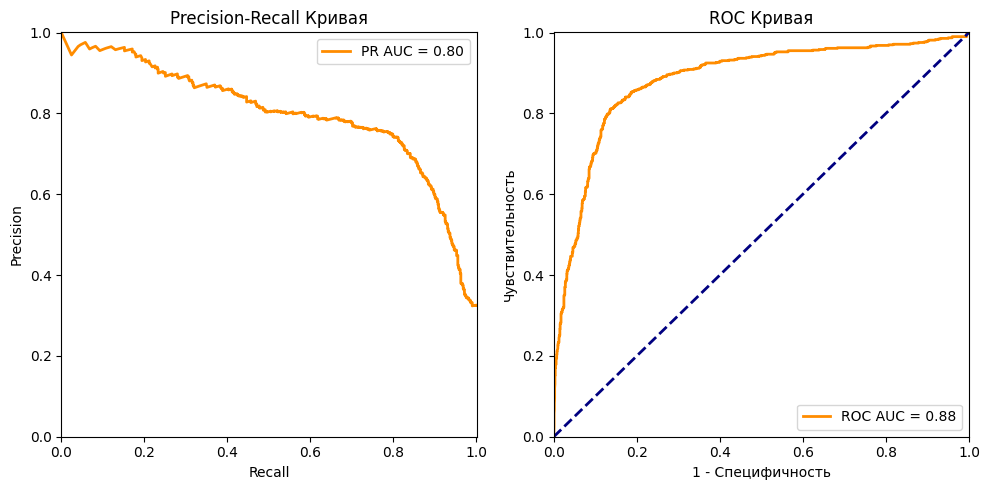

In [29]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

all_probs = []  # Здесь будут храниться вероятности для всех данных
all_labels = []  # Здесь будут храниться истинные метки

with torch.no_grad():
    for i, data in enumerate(valid_loader):
        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1, 2))
        probs = F.softmax(outputs, dim=1)
        all_probs += [probs[0][1].numpy()]
        all_labels += list(labels.numpy())

# Преобразование в массивы numpy
y_probs = np.array(all_probs)
y_true = np.array(all_labels)

# Расчет Precision-Recall  и AUC-PR
precision, recall, _ = precision_recall_curve(y_true, y_probs)
auc_pr = auc(recall, precision)

# Расчет ROC-кривой и AUC-ROC
fpr, tpr, _ = roc_curve(y_true, y_probs)
auc_roc = auc(fpr, tpr)

# Рассчет чувствительности (True Positive Rate) и специфичности (True Negative Rate)
sensitivity = tpr
specificity = 1 - fpr

# Построение PR-кривой
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR AUC = {auc_pr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0,1.0005])
plt.ylim([0,1.0005])
plt.title('Precision-Recall Кривая')
plt.legend(loc='best')

# Построение ROC-кривой
plt.subplot(1, 2, 2)
plt.plot(1- specificity, sensitivity, color='darkorange', lw=2, label=f'ROC AUC = {auc_roc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('1 - Специфичность')
plt.ylabel('Чувствительность')
plt.title('ROC Кривая')
plt.legend(loc='best')
plt.xlim([0,1.0005])
plt.ylim([0,1.0005])
plt.tight_layout()
plt.show()


In [18]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix_new(cm, classes=['здоров','болен'], normalize=False, title='Матрица ошибок', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Истинный класс')
    plt.xlabel('Предсказанный класс')

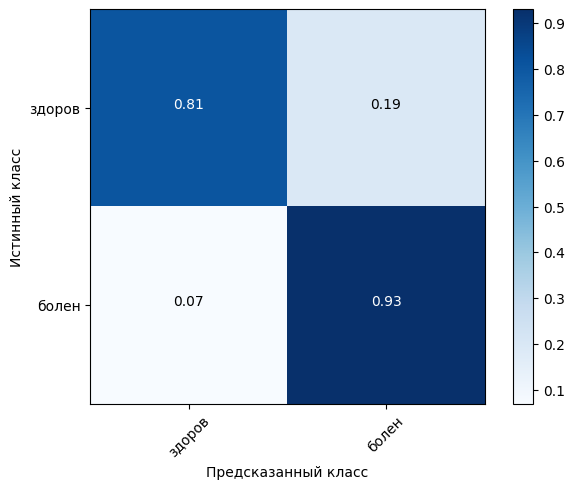

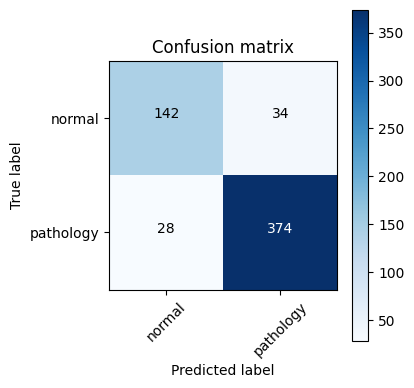

In [19]:
cm = confusion_matrix(all_labels, all_preds)
plot_confusion_matrix_new(cm, classes=['здоров','болен'], normalize=True, title='')

plt.figure(figsize=(4,4))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)

In [35]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.84      0.81      0.82       176
           1       0.92      0.93      0.92       402

    accuracy                           0.89       578
   macro avg       0.88      0.87      0.87       578
weighted avg       0.89      0.89      0.89       578



### __ОБЩИЙ ВЫВОД:__

Для задачи бинарной классификации лучшая модель оказалась та, обучение которой производилось без lr шедулера с использованием МaxScalling, взвешенного семплирования и без добавления шума на тренировочной трансформации. 

Лучших результатов такая модель достигла к 25 эпохе обучения, показав результат 0.893 weighted avg f1 и 0.892 по acc

__Можно утвердать, что подходы с представлением ВЭКГ в виде фотографий и в виде облака точек имеют при лучших подобранных гиперпараметрах примерно одинаковые результаты качества: Сеть на архитектуре pointnet хоть и добилась значения weighted avg f1 и acc почти на 0.08 выше.__

